# Imports

In [10]:
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'figure.figsize':(11,7), 'figure.dpi':120})
image_dest = 'results_images/'

In [11]:
startTime = time.time()

## Load Data

In [12]:
#filename = '../../002_Data/Release_4/log_ready.pickle'
#filename = '../../002_Data/Release_4/log_ready_geo.pickle'
#filename = '../../002_Data/Release_4/log_ready_all.pickle'
filename = '../../002_Data/Release_4/cox_time_ready.pickle'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
df.columns.to_list()

['PAST_DUE',
 'TOTAL_60_DAYS_AMT',
 'NUM_PREM_FOR_PER',
 'BREAK_ARRANGEMENT',
 'COVID_REMINDER',
 'MULTI_DWELL_SIZE',
 'SNAP_GEO',
 'NUM_PER_FOR_PREM',
 'HAS_COTENANT',
 'SPA_PER_ID',
 'CMIS_MATCH',
 'start',
 'stop']

In [13]:
df = df.drop(['start', 'stop'], axis=1)
df.columns.to_list()

['PAST_DUE',
 'TOTAL_60_DAYS_AMT',
 'NUM_PREM_FOR_PER',
 'BREAK_ARRANGEMENT',
 'COVID_REMINDER',
 'MULTI_DWELL_SIZE',
 'SNAP_GEO',
 'NUM_PER_FOR_PREM',
 'HAS_COTENANT',
 'SPA_PER_ID',
 'CMIS_MATCH']

# Setup

In [14]:
import statsmodels.api as sm
from custom_methods import model_eval
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

event_col = 'CMIS_MATCH'
id_col = 'SPA_PER_ID'
model = 'logit'
cutoffs = [0.001, 0.005, 0.01, 0.05]
scaler = None
sampler = None
#scaler = StandardScaler()
#sampler = RandomOverSampler(sampling_strategy='minority', random_state=42)

# Run Model on All Data

In [15]:
#exog = np.asarray(sm.add_constant(df.drop([id_col, event_col], axis=1)), dtype='float')
exog = np.asarray(df.drop([id_col, event_col], axis=1), dtype='float')
endog = np.asarray(df[event_col], dtype='bool')

model_all = sm.Logit(endog=endog, exog=exog).fit(disp=True)

print(model_all.summary(
    yname=event_col, 
    #xname=['Intercept']+df.columns.drop([id_col, event_col]).to_list())
    xname=df.columns.drop([id_col, event_col]).to_list())
     )

Optimization terminated successfully.
         Current function value: 0.046888
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             CMIS_MATCH   No. Observations:               632511
Model:                          Logit   Df Residuals:                   632502
Method:                           MLE   Df Model:                            8
Date:                Fri, 28 May 2021   Pseudo R-squ.:                -0.01161
Time:                        08:22:42   Log-Likelihood:                -29657.
converged:                       True   LL-Null:                       -29317.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
PAST_DUE              0.1402      0.005     29.202      0.000       0.131       0.150
TOTAL_60

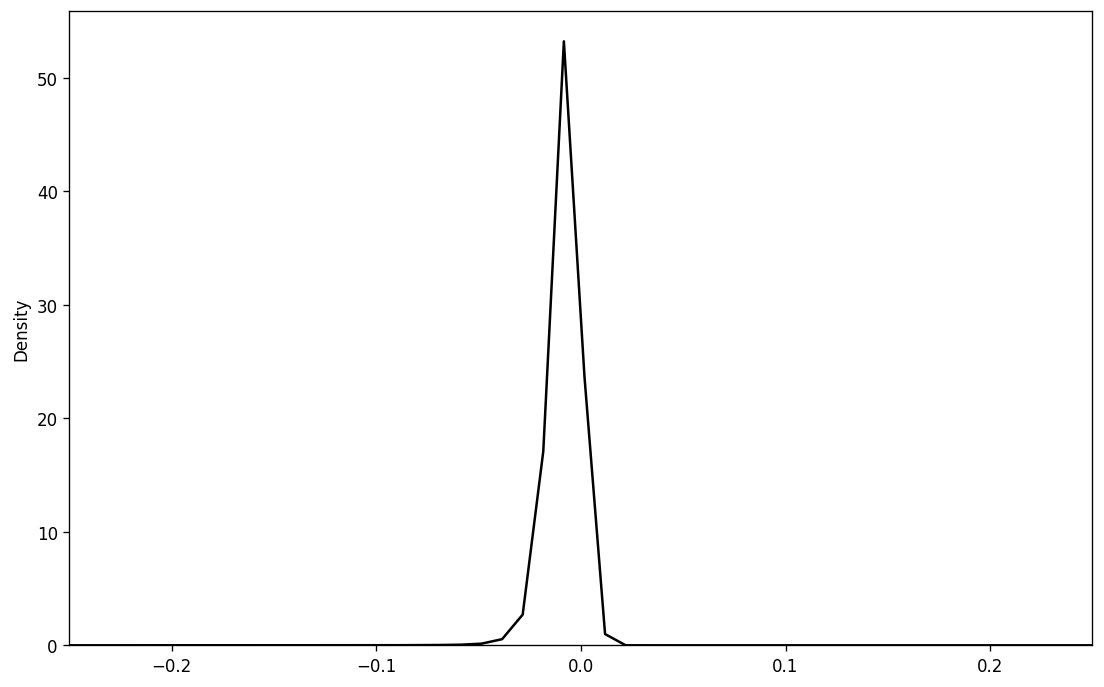

In [16]:
# np.arange(0, model_all.resid_response.size, 1)
sns.kdeplot(x=model_all.resid_response, color='black')
plt.xlim((-0.25,0.25));
#plt.savefig(fname=image_dest+'Log_resids.png')

In [17]:
#Log-Likelihood:                -1840.6

In [18]:
summary_as_html = model_all.summary(
    alpha=0.05,
    yname=event_col, 
    #xname=['Intercept']+df.columns.drop([id_col, event_col]).to_list()
    xname=df.columns.drop([id_col, event_col]).to_list()
).tables[1].as_html()

summary_as_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
summary_as_df['exp(coef)'] = np.exp(model_all.params)
summary_as_df[['[0.025', '0.975]']] = np.exp(model_all.conf_int())
summary_as_df = summary_as_df[['coef', 'exp(coef)', 'P>|z|','[0.025', '0.975]']].rename({'P>|z|':'p'}, axis=1)

print(summary_as_df.to_latex(float_format='%.3f'))

\begin{tabular}{lrrrrr}
\toprule
{} &   coef &  exp(coef) &     p &  [0.025 &  0.975] \\
\midrule
PAST\_DUE          &  0.140 &      1.151 & 0.000 &   1.140 &   1.161 \\
TOTAL\_60\_DAYS\_AMT &  0.001 &      1.001 & 0.000 &   1.001 &   1.001 \\
NUM\_PREM\_FOR\_PER  & -4.897 &      0.007 & 0.000 &   0.007 &   0.008 \\
BREAK\_ARRANGEMENT &  0.398 &      1.489 & 0.000 &   1.364 &   1.626 \\
COVID\_REMINDER    &  0.000 &      1.000 & 0.989 &   0.982 &   1.019 \\
MULTI\_DWELL\_SIZE  &  0.007 &      1.007 & 0.000 &   1.005 &   1.009 \\
SNAP\_GEO          & -0.492 &      0.611 & 0.000 &   0.514 &   0.726 \\
NUM\_PER\_FOR\_PREM  & -0.200 &      0.819 & 0.000 &   0.778 &   0.863 \\
HAS\_COTENANT      & -0.435 &      0.647 & 0.000 &   0.606 &   0.691 \\
\bottomrule
\end{tabular}



In [19]:
model_all.aic

59332.04998035972

In [20]:
model_all.prsquared

-0.011608229730456943

# K-Folds

## Run

In [21]:
predictions = model_eval.k_folds(
    df = df, 
    event_col = event_col,
    id_col = id_col, 
    k = 4, 
    model = model, 
    scaler = scaler,
    sampler = sampler,
)

#predictions.head()

In [22]:

filename = '../../002_Data/Release_4/log_predictions0.pickle'
outfile = open(filename, 'wb')
pickle.dump(predictions, outfile)
outfile.close()


## Summary

In [23]:
summary_recall0 = model_eval.find_recall_val(predictions, recall_threshold=0.92)
summary_recall0

,Number Predicted,Actual Number,False P/N Rate,Precision,Recall,f-1,Custom
Case,,,,,,,
Positive,572000,5028,0.904208,0.008086,0.919849,0.016030,0.463967
Negative,60511,627483,0.080151,0.993340,0.095792,0.174734,0.544566


In [25]:
summary_recall = summary_recall0.copy()

In [26]:
summary_recall['Actual Number'] = (summary_recall['Number Predicted'] * summary_recall['Precision']).astype('int')
summary_recall = summary_recall.drop('Custom', axis=1).rename(
    {'Number Predicted':'Predicted', 'Actual Number':'Hits', 'False P/N Rate':'False P/N'}, axis=1)
summary_recall.index.names = ['Class']

to_change = ['False P/N', 'Precision', 'Recall', 'f-1']
for i in to_change:
    summary_recall[i] = summary_recall[i].astype('float')

print(summary_recall.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Predicted &   Hits &  False P/N &  Precision &  Recall &  f-1 \\
Class    &            &        &            &            &         &      \\
\midrule
Positive &     572000 &   4625 &       0.90 &       0.01 &    0.92 & 0.02 \\
Negative &      60511 &  60108 &       0.08 &       0.99 &    0.10 & 0.17 \\
\bottomrule
\end{tabular}



In [27]:
summary = model_eval.get_summary(predictions)
summary

Threshold_Value  Number Predicted  Actual Number  \
Max_Of    Case                                                         
Precision Positive         0.409785                10           5028   
          Negative         0.409785            632501         627483   
Recall    Positive         0.000007            632510           5028   
          Negative         0.000007                 1         627483   
f-1       Positive         0.016446             47348           5028   
          Negative         0.016446            585163         627483   
Custom    Positive         0.000018            632427           5028   
          Negative         0.000018                84         627483   

                    False P/N Rate  Precision   Recall      f-1   Custom  
Max_Of    Case                                                            
Precision Positive        0.000014   0.100000 0.000199 0.000397 0.050099  
          Negative        0.999801   0.992052 0.999986 0.996003 0.996019  
Recall    Positive        0.999998   0.007949 1.000000 0.015773 0.503975  
          Negative        0.000000   1.000000 0.000002 0.000003 0.500001  
f-1       Positive        0.074002   0.019283 0.181583 0.034863 0.100433  
          Negative        0.818417   0.992968 0.925998 0.958314 0.959483  
Custom    Positive        0.999866   0.007950 1.000000 0.015775 0.503975  
          Negative        0.000000   1.000000 0.000134 0.000268 0.500067

In [28]:
'''
TYPICAL: test set smaller
k, precision, f-1
2, 0.142857, 0.072115 (same number of people in training and test)
2, 0.066667, 0.067715
3, 0.111111, 0.064246
3, 0.083333, 0.063988
4, 0.083333, 0.069744
5, 0.083333, 0.070064
7, 0.071429, 0.066090

INVERTED: test set larger
k, precision, f-1
3, 0.071429, 0.063761
4, 0.074627, 0.063627
5, 0.050000, 0.059262
6, 0.056133, 0.059815
Overall, predicting on more than entire dataset - many predictions!
'''

'\nTYPICAL: test set smaller\nk, precision, f-1\n2, 0.142857, 0.072115 (same number of people in training and test)\n2, 0.066667, 0.067715\n3, 0.111111, 0.064246\n3, 0.083333, 0.063988\n4, 0.083333, 0.069744\n5, 0.083333, 0.070064\n7, 0.071429, 0.066090\n\nINVERTED: test set larger\nk, precision, f-1\n3, 0.071429, 0.063761\n4, 0.074627, 0.063627\n5, 0.050000, 0.059262\n6, 0.056133, 0.059815\nOverall, predicting on more than entire dataset - many predictions!\n'

In [29]:
model_eval.print_summary(summary)

\begin{tabular}{llrrrrrr}
\toprule
       &   &  Predicted &    Hits &  False P/N &  Precision &  Recall &  f-1 \\
Max\_Of & Class &            &         &            &            &         &      \\
\midrule
Precision & P &         10 &       1 &       0.00 &       0.10 &    0.00 & 0.00 \\
       & N &     632501 &  627474 &       1.00 &       0.99 &    1.00 & 1.00 \\
Recall & P &     632510 &    5028 &       1.00 &       0.01 &    1.00 & 0.02 \\
       & N &          1 &       1 &       0.00 &       1.00 &    0.00 & 0.00 \\
f-1 & P &      47348 &     913 &       0.07 &       0.02 &    0.18 & 0.03 \\
       & N &     585163 &  581048 &       0.82 &       0.99 &    0.93 & 0.96 \\
Custom & P &     632427 &    5028 &       1.00 &       0.01 &    1.00 & 0.02 \\
       & N &         84 &      84 &       0.00 &       1.00 &    0.00 & 0.00 \\
\bottomrule
\end{tabular}



# Print Time

In [30]:
from custom_methods.calc_time import calc_time_from_sec

calc_time_from_sec(time.time() - startTime)

hours:minutes:seconds = 2:51:18.06928777694702
